In [1]:
%pylab inline

import pandas as pd
import pickle
import matplotlib.dates as md
import statsmodels.api as sm
import scipy.stats as dists

from scipy.optimize import minimize

tableau = pickle.load(open('tableau.colors', 'rb'))

rcParams['figure.figsize'] = (10,8)
rcParams['axes.grid'] = True
rcParams['lines.linewidth'] = 2.5
rcParams['axes.prop_cycle'] = cycler('color', tableau)

xfmt = md.DateFormatter('%H:%M:%S')

Populating the interactive namespace from numpy and matplotlib


In [21]:
trades = pd.read_csv('../GDAX/data/2016-10-06.trades.csv', index_col=0)
trades.t = pd.to_datetime(trades.t*1e9)

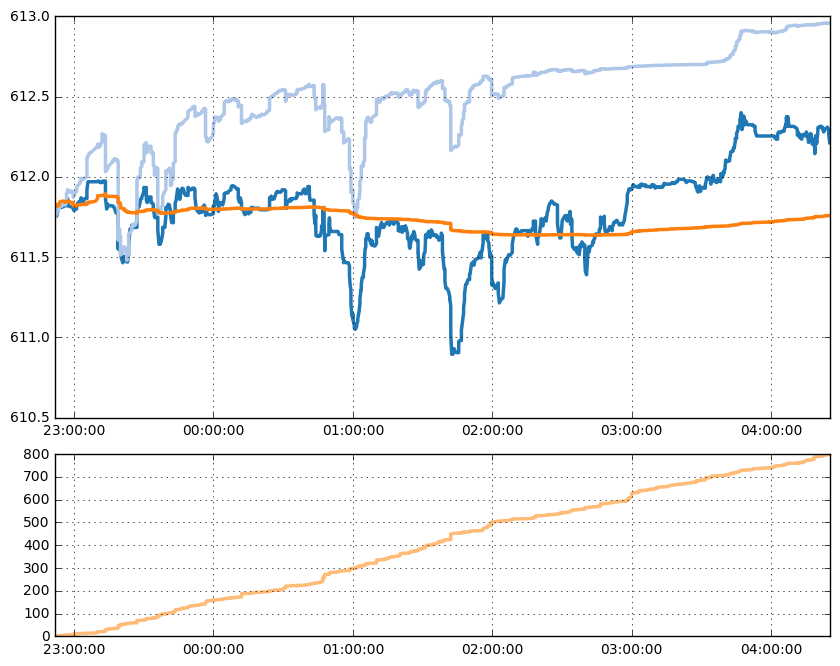

In [25]:
ax = []
ax.append(subplot2grid((3,1),(0,0), rowspan=2))
ax.append(subplot2grid((3,1),(2,0)))

ax[0].plot(trades.t, trades.mid)
ax[0].plot(trades.t, trades.est)
ax[0].plot(trades.t, (trades.px * trades.sz).cumsum() / trades.sz.cumsum())
ax[1].plot(trades.t, trades.sz.cumsum(), c=tableau[3])

ax[0].xaxis.set_major_formatter(xfmt)
ax[1].xaxis.set_major_formatter(xfmt)